In [1]:
import numpy as np
import numpy.linalg as la
import cvxpy as cp

from functools import partial

  
import matplotlib.pyplot as plt
import labellines as ll


from shapely.geometry import Point
from descartes import PolygonPatch


In [2]:
# The differentiable kernel function with parameters c,l not filled.
def h(r,c,l):
    return c * np.exp(-(r**2) / l**2)

def k(x1,x2,c,l):
    small_sig = 1e-10 # This is needed for numerical stability.
    return h(np.linalg.norm(x1-x2+small_sig,axis = -1),c,l)

def Gram(kernel,x):
    KA = kernel(x[:,np.newaxis,:],x)
    return KA

In [3]:
def h_inv(y,c,l):
    return np.sqrt(np.log(c/y))*l

In [4]:
kernel = partial(k,c=1,l=1)

# Set up the reference points

In [23]:
nx, ny = (4, 4)
x = np.linspace(-2, 4, nx)
y = np.linspace(-2, 4, ny)
xv, yv = np.meshgrid(x, y)

ref = np.array([xv.ravel(),yv.ravel()]).T

uniform_radius = 9
Rs = np.ones(len(ref))*uniform_radius

K = Gram(kernel,ref)

l,U =la.eig(K)

M = np.diag(1/np.sqrt(l)).dot(U) # M.T.dot(M) = K^{-1} is satisfied.

# Another idea of choosing M, not from the eigen decomp approach though.
M = la.cholesky(la.inv(K)).T

# Set up the true x locations

In [24]:
x_true = np.array([[0,0],[0,1],[1,1],[2,1],[2,2],[2,3],[3,3],[4,3],[4,4]])
S = Gram(kernel,x_true)

# Define some constants

In [25]:
N = len(ref)
T = len(x_true)

# Define the decision variables that represent the feature matrix, solve for an feasible solution.

In [34]:
H = h(Rs,c=1,l=1).reshape(-1,1)

H.dot(np.ones((1,T))).shape

phi = cp.Variable((N,T))

constraints = [la.inv(M) @ phi>= H.dot(np.ones((1,T)))]
# constraints = [la.inv(M) @ phi>= 0]


prob=cp.Problem(cp.Maximize(0),constraints)

prob.solve()

phi0 = phi.value

phi_prev=phi0

# Perform the alternating solver

In [69]:
for _ in range(200):
    prob = cp.Problem(cp.Minimize(cp.norm(S-phi.T @ phi_prev)**2+0.1*cp.norm(phi-phi_prev)**2),constraints)
    prob.solve()
    phi_prev = phi.value
    print(prob.value,)

8.844036296819255e-09
8.267303631114413e-09
8.77004096231882e-09
9.343989815534198e-09
8.656415270602428e-09
7.848546974121986e-09
8.283144790607915e-09
8.525982974252128e-09
8.630303583307895e-09
8.24521800359171e-09
7.843304407124524e-09
7.152851851718582e-09
6.983726369862378e-09
6.907402856019027e-09
6.328910503408384e-09
6.567587880960948e-09
5.10018291224827e-09
5.798112492976131e-09
5.5050356951680726e-09
6.420595754531799e-09
6.929650575385119e-09
5.698392053719771e-09
5.854702666586755e-09
5.849184813824139e-09
7.118775194096009e-09
6.2609961254937795e-09
6.8349650595629665e-09
6.412486398040534e-09
6.318347043745266e-09
5.8467500788470536e-09
5.80383518829113e-09
6.2131957672358775e-09
6.308105967731945e-09
7.248792292190239e-09
6.6071778678621295e-09
7.161724483023724e-09
6.135804523789045e-09
6.854317290541419e-09
6.675185165943852e-09
6.772328992006979e-09
6.115580320664563e-09
6.90674904220437e-09
5.8883049960876036e-09
6.612079690618279e-09
5.688930835349979e-09
8.163370

# The solution $\phi$ is good enough using alternating method.

# However, using the distance inversion to solve for the sample locations is very unsuccessful. Big error propagates to the end.
# Therefore, I will directly apply Scipy to recover locations from the $\phi$ in the next notebook.

# Invert the feature to get the distance matrix.

In [54]:
Rhats = h_inv(la.inv(M).dot(phi_prev),c=1,l=1)

/tmp/ipykernel_102238/2812365218.py:2: RuntimeWarning: invalid value encountered in log
  return np.sqrt(np.log(c/y))*l


# Call localization toolbox to recover the sample locations

In [42]:
from Localization import substitution_multi_lateration,iterative_multi_lateration

In [75]:
R_ref = la.norm(ref[:,np.newaxis,:]-ref,axis=-1)
sample_locs = []
for i in range(T):
    positives = np.logical_not(np.isnan(Rhats[:,i]))
    init_guess = substitution_multi_lateration(ref[positives],Rhats[:,i][positives])

    init_guess = init_guess.reshape(1,-1)

#     guess=init_guess
    guess = iterative_multi_lateration(ref,init_guess,np.vstack([np.hstack([R_ref,Rhats[:,i].reshape(-1,1)]),np.hstack([Rhats[:,i],0])]),epsilon=1e-6)
    
    sample_locs.append(guess)

In [76]:
sample_locs = np.array(sample_locs).reshape(T,-1)

In [79]:
sample_locs

array([[        nan,         nan],
       [ 3.53815475, -1.65796258],
       [-0.82142096,  0.03747007],
       [ 1.52859934,  0.68450813],
       [ 1.53268019, -0.50990484],
       [ 0.56731413,  0.34095244],
       [ 2.99412312,  1.67742773],
       [ 0.02202523,  1.32810777],
       [        nan,         nan]])

In [83]:
from RKHS import feature

In [92]:
feature(kernel, ref,sample_locs[1])

array([ 0.12794087, -0.07344097,  0.28783819,  0.23326942, -0.00492678,
        0.00513134,  0.27147379, -0.18456185, -0.24456801,  0.2059295 ,
       -0.00925427, -0.0547045 ,  0.01005783,  0.01005412, -0.36321094,
        0.13778998])

In [91]:
phi_prev[:,1]

array([ 6.86212868e-04,  3.43486074e-04, -1.65982872e-02,  9.54376339e-01,
        2.71524279e-01, -2.20248596e-03,  1.44199290e-04,  1.85451616e-03,
       -1.14156631e-03,  1.20128060e-01,  2.61455134e-04, -3.52059320e-04,
        3.10929039e-04,  5.94293355e-06, -4.49092388e-04,  2.60032576e-02])

In [77]:
sols = {
#     'Reference points':ref,\
        'Sample Locs':sample_locs,'Truth':x_true}

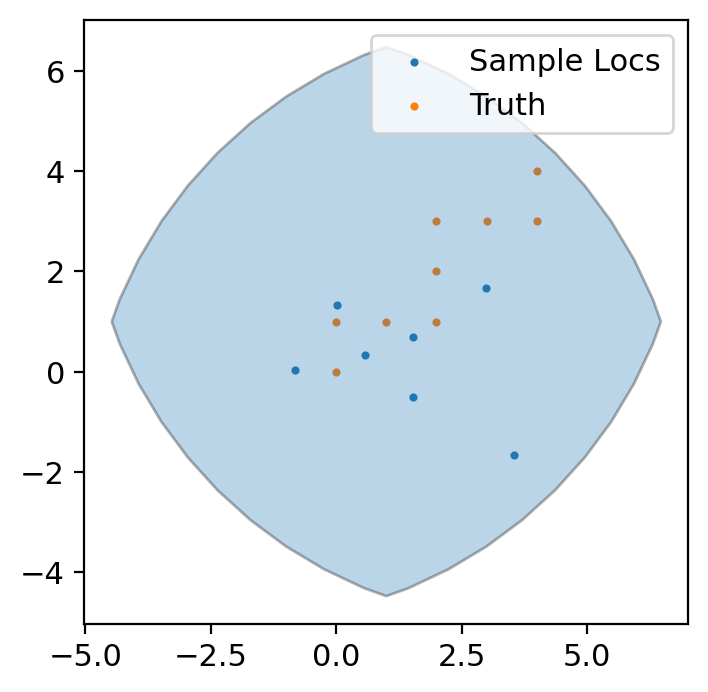

In [78]:
plt.rc('font',size=11)
plt.figure(dpi=200)
for key,val in sols.items():
    plt.scatter(val[:,0],val[:,1],marker = '.',s = 15,label=key)
    
    plt.gca().set_aspect('equal')
#     plt.show()

    
points = [Point(*x) for x in ref]
constraint_set  = None

for p,r in zip(points,Rs):
    
    if constraint_set is None:
        constraint_set = p.buffer(r)
    else:
        constraint_set = constraint_set.intersection(p.buffer(r))

plt.gca().add_patch(PolygonPatch(constraint_set,alpha=0.3))

# plt.text(-2,0.9,r'Constraint Set for $x_i$')

# plt.xlim((-5,8))
# plt.ylim((-5,8))
# plt.legend()
# plt.show()
# circ = plt.Circle(search_region_center,search_region_radius,label='Search Region Boundary',fill=False)
# plt.gca().add_patch(circ)
# ll.labelLines(plt.gca().get_lines(),fontsize=12,zorder=3,yoffsets=1.5,align=False)
plt.legend()
plt.show()